# Saline Level Detection

This notebook implements a complete workflow to train a convolutional neural network (CNN) for classifying the fill level of saline bottles. 

Dataset used: 
1. DOI: 10.17632/9mcj3rvvxb.1
2. DOI: 10.17632/n8k2zfr6xm.2

### 1. Environment Setup

This first cell imports all necessary libraries and defines the core configuration parameters for the project.
- **Libraries:** TensorFlow/Keras for model building, PIL/OpenCV for image manipulation, and Scikit-learn/Seaborn for evaluation.
- **Paths:** Defines the paths to the input dataset and the working directory for saving processed files.
- **Parameters:**
    - `CLASS_NAMES`: The four categories for our classification task.
    - `IMG_SIZE`: Set to **32x32 pixels**. 

In [3]:
# Import all necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as pil_image
import PIL.ImageOps
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# --- Main Configuration ---
ORIGINAL_DATA_PATH = '/kaggle/input/iv-fluids-level-dataset/dataset'
WORKING_DIR = '/kaggle/working/'

IMG_SIZE = 32 
BATCH_SIZE = 32
CLASS_NAMES = ['sal_data_empty', 'sal_data_50', 'sal_data_80', 'sal_data_100']

TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### 2. Generating the Data Label File

The first data handling step is to create a text file that maps every image to its corresponding class label (based on its folder name).

This cell replicates that process by creating `saline_data_label.txt`. This file serves as a manifest for all subsequent preprocessing steps.

In [4]:

data_label_path = os.path.join(WORKING_DIR, 'data_label')
os.makedirs(data_label_path, exist_ok=True)
label_file_path = os.path.join(data_label_path, 'saline_data_label.txt')

print("Generating label file...")
with open(label_file_path, 'w') as data_file:
    for dir_name in sorted(os.listdir(ORIGINAL_DATA_PATH)): 
        if dir_name in CLASS_NAMES:
            img_path_full = os.path.join(ORIGINAL_DATA_PATH, dir_name)
            for img_name in os.listdir(img_path_full):
                line = f"{dir_name}/{img_name}\n"
                data_file.write(line)
print(f"Label file created at: {label_file_path}")

Generating label file...
Label file created at: /kaggle/working/data_label/saline_data_label.txt


### 3. Preprocessing Pipeline

1.  **Negative Filter (Invert):** A negative filter is applied to each image. The authors note this was done "to emphasize the transparency of saline solution's filling level."
2.  **Resize:** Each inverted image is resized to **32x32 pixels** to match the required input shape of the model architecture.

The newly processed images are saved to a separate directory (`processed_images_paper_spec`) to keep the original dataset untouched.

In [5]:
# This cell applies the exact preprocessing: Invert filter and 32x32 resize.
PROCESSED_DATA_PATH = os.path.join(WORKING_DIR, 'processed_images_paper_spec')
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

for name in CLASS_NAMES:
    os.makedirs(os.path.join(PROCESSED_DATA_PATH, name), exist_ok=True)
    
print(f"Starting image preprocessing (Invert + Resize to {IMG_SIZE}x{IMG_SIZE})...")

with open(label_file_path, "r") as f:
    lines = f.readlines()

for line in lines:
    try:
        line = line.strip()
        label, file_name = line.split("/")
        
        original_file_path = os.path.join(ORIGINAL_DATA_PATH, label, file_name)
        img = pil_image.open(original_file_path)

        # 1. Apply negative filter 
        inverted_img = PIL.ImageOps.invert(img) 
        
        # 2. Resize to 32x32 
        resized_img = inverted_img.resize((IMG_SIZE, IMG_SIZE), pil_image.LANCZOS)
        
        # 3. Ensure RGB format
        if resized_img.mode != 'RGB':
            resized_img = resized_img.convert('RGB')
            
        # 4. Save the processed image
        save_path = os.path.join(PROCESSED_DATA_PATH, label, file_name)
        resized_img.save(save_path)
        
    except Exception as e:
        print(f"Error processing {line}: {e}")

print(f"\nPreprocessing complete.")

Starting image preprocessing (Invert + Resize to 32x32)...

Preprocessing complete.


### 4. Creating Data Splits for Robust Training

To properly train and evaluate a machine learning model, the data must be split into three distinct sets:
- **Training Set (80%):** The data the model learns from.
- **Validation Set (10%):** Data used after each epoch to check the model's performance on unseen data, guide hyperparameter tuning, and prevent overfitting.
- **Test Set (10%):** Data held back until the very end. It is used only once to get a final, unbiased assessment of the trained model's real-world performance.

This cell performs an 80/10/10 split on our preprocessed images, ensuring that each set has a proportional representation of all four classes (`stratify`).

In [6]:
# Create Train/Validation/Test split from the preprocessed images
SPLIT_DATA_PATH = os.path.join(WORKING_DIR, 'split_data_paper_spec')

if os.path.exists(SPLIT_DATA_PATH):
    shutil.rmtree(SPLIT_DATA_PATH)

train_dir = os.path.join(SPLIT_DATA_PATH, 'train')
val_dir = os.path.join(SPLIT_DATA_PATH, 'validation')
test_dir = os.path.join(SPLIT_DATA_PATH, 'test')

os.makedirs(train_dir); os.makedirs(val_dir); os.makedirs(test_dir)

all_files = []
for class_name in CLASS_NAMES:
    class_path = os.path.join(PROCESSED_DATA_PATH, class_name)
    os.makedirs(os.path.join(train_dir, class_name)); os.makedirs(os.path.join(val_dir, class_name)); os.makedirs(os.path.join(test_dir, class_name))
    files = os.listdir(class_path)
    for f in files:
        all_files.append((os.path.join(class_path, f), class_name))

# Use an 80/10/10 split
train_val_files, test_files = train_test_split(all_files, test_size=0.10, random_state=42, stratify=[label for _, label in all_files])
train_files, val_files = train_test_split(train_val_files, test_size=1/9, random_state=42, stratify=[label for _, label in train_val_files])

def copy_files_to_split(files, dest_base_dir):
    for file_path, class_name in files:
        shutil.copy(file_path, os.path.join(dest_base_dir, class_name))

copy_files_to_split(train_files, train_dir)
copy_files_to_split(val_files, val_dir)
copy_files_to_split(test_files, test_dir)

print("Data splitting complete.")

Data splitting complete.


### 5. Preparing the Data Pipeline

This cell sets up the `ImageDataGenerator` to feed data to the model.

**Crucial Step:** A baseline model **"trained without augmentation."**

To faithfully replicate their success, we will also turn off all augmentation for the training set. The only transformation applied by the generator is `rescale=1./255`, which normalizes pixel values from the `[0, 255]` range to the `[0, 1]` range, a standard practice for neural networks.

In [7]:
# The generator will only rescale pixel values from 0-255 to 0-1.
print("Creating data generators WITHOUT augmentation to match the paper's benchmark...")

datagen_no_aug = ImageDataGenerator(rescale=1./255)

train_generator = datagen_no_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True 
)

validation_generator = datagen_no_aug.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen_no_aug.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Creating data generators WITHOUT augmentation to match the paper's benchmark...
Found 3373 images belonging to 4 classes.
Found 422 images belonging to 4 classes.
Found 422 images belonging to 4 classes.


### 6. Building the CNN Architecture

This cell defines the neural network using the Keras Sequential API. 

The model consists of:
- An input layer expecting `32x32x3` images.
- Two main convolutional blocks, each containing:
    - Two `Conv2D` layers for feature extraction.
    - A `MaxPooling2D` layer to downsample and retain important features.
    - A `Dropout` layer to prevent overfitting.
- A classifier head that flattens the feature maps and uses `Dense` layers to make the final prediction via a `softmax` activation function.

In [8]:
print("Building the exact model architecture from the paper...")
model = Sequential([
    # The input shape is 32x32 
    InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # First Block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu'), # Default padding is 'valid'
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu'), # Default padding is 'valid'
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Classifier Head
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASS_NAMES), activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Building the exact model architecture from the paper...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1750356426.087292      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750356426.088121      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,247,780 (4.76 MB)

 Trainable params: 1,247,780 (4.76 MB)

 Non-trainable params: 0 (0.00 B)

### 7. Training the Neural Network

This cell executes the model training process using `model.fit()`.

We are using two important Keras callbacks:
- **`ModelCheckpoint`**: This will monitor the validation accuracy after each epoch and save the model only when it improves. This ensures that we keep the best version of the model discovered during training.
- **`EarlyStopping`**: This will monitor the validation loss and stop the training process automatically if the performance does not improve for a set number of epochs (`patience=25`). This prevents overfitting and saves computational time.

We set our maximum epochs to 200, expecting `EarlyStopping` to halt the process within a similar range.

In [9]:
# Train the model.
EPOCHS = 200

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=25,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    os.path.join(WORKING_DIR, 'paper_replication_model.h5'), 
    monitor='val_accuracy', 
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1750356436.803657     128 service.cc:148] XLA service 0x7a66a8004e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750356436.808447     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750356436.808474     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750356437.363983     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


 17/106 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2601 - loss: 1.4197

I0000 00:00:1750356443.000357     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2710 - loss: 1.3956
Epoch 1: val_accuracy improved from -inf to 0.30569, saving model to /kaggle/working/paper_replication_model.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.2713 - loss: 1.3953 - val_accuracy: 0.3057 - val_loss: 1.3566
Epoch 2/200
103/106 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3780 - loss: 1.3121
Epoch 2: val_accuracy improved from 0.30569 to 0.46682, saving model to /kaggle/working/paper_replication_model.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3790 - loss: 1.3112 - val_accuracy: 0.4668 - val_loss: 1.1767
Epoch 3/200
102/106 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5122 - loss: 1.1185
Epoch 3: val_accuracy improved from 0.46682 to 0.57820, saving model to /kaggle/working/paper_replication_model.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5134 - loss: 1.1171 - val_accuracy: 0.5782 - val_loss: 1.0051
Epoch 4/200
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

### 8. Visualizing Training History and Final Evaluation

After training is complete, it's essential to evaluate the model's performance. This cell performs two key tasks:

1.  **Plotting Learning Curves:** It visualizes the model's `accuracy` and `loss` for both the training and validation sets over each epoch. This helps us understand if the model learned effectively and whether it overfit the training data.
2.  **Final Test Evaluation:** It loads the best model saved by `ModelCheckpoint` and evaluates its performance on the **unseen test set**. This provides the final, unbiased measure of the model's accuracy.

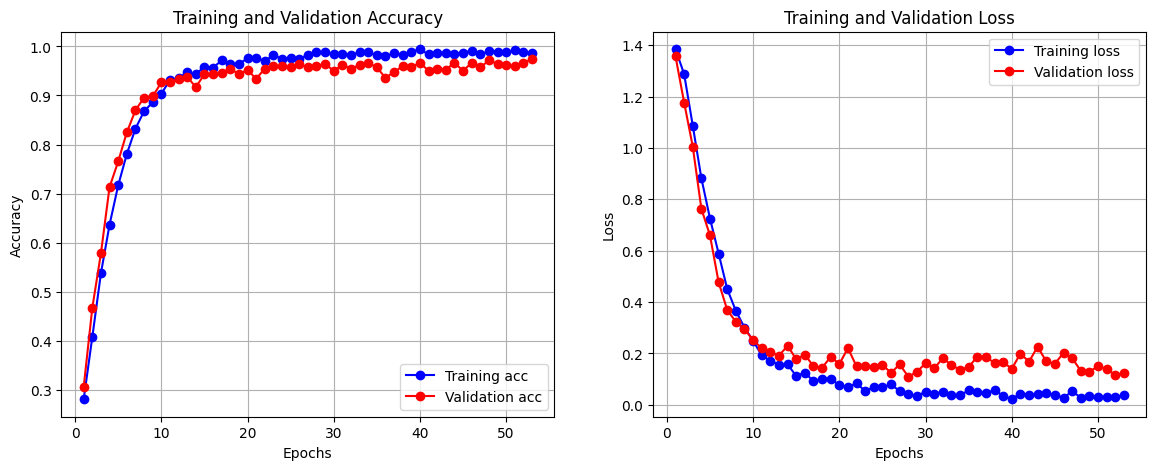

Loading the best model saved during training...

Evaluating model on the test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9663 - loss: 0.1129

Final Test Accuracy: 0.9526
Final Test Loss: 0.1612


In [10]:
# Plot training history to visualize learning
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.show()

plot_history(history)

# Load the best performing model and evaluate on the unseen test set
print("Loading the best model saved during training...")
best_model = load_model(os.path.join(WORKING_DIR, 'paper_replication_model.h5'))

print("\nEvaluating model on the test set...")
test_loss, test_acc = best_model.evaluate(test_generator, verbose=1)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')
print(f'Final Test Loss: {test_loss:.4f}')

### 9. In-Depth Performance Analysis

To get a more granular understanding of the model's behavior, we generate two key reports:

- **Classification Report:** This provides class-wise metrics, including:
    - **Precision:** Of all the times the model predicted a certain class, how often was it correct?
    - **Recall:** Of all the actual instances of a class, how many did the model correctly identify?
    - **F1-Score:** The harmonic mean of precision and recall, providing a single score for a class's performance.

- **Confusion Matrix:** This is a powerful visualization that shows exactly where the model is making mistakes. The diagonal represents correct predictions, while off-diagonal cells show which classes are being confused with one another.

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

Classification Report:

                precision    recall  f1-score   support

  sal_data_100       0.94      0.98      0.96       106
   sal_data_50       0.96      0.93      0.95       105
   sal_data_80       0.94      0.97      0.95       106
sal_data_empty       0.98      0.92      0.95       105

      accuracy                           0.95       422
     macro avg       0.95      0.95      0.95       422
  weighted avg       0.95      0.95      0.95       422


Confusion Matrix:



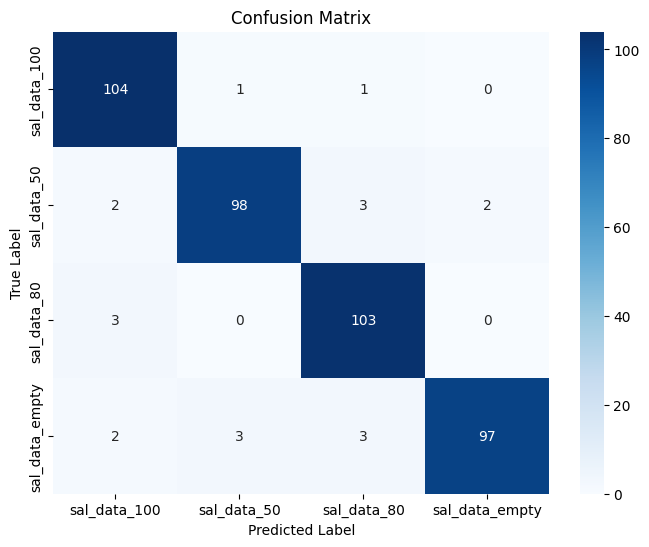

In [11]:
# Generate detailed performance metrics
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_labels = sorted(test_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()